*Summary by: Dr. Carolina Perdomo for QuantumQuipu.*

We are living in an exciting era marked by the advent of quantum computing, a technological leap that holds the potential to revolutionize problem-solving by using the power of quantum mechanics. These quantum devices, often referred to as *Noisy Intermediate-Scale Quantum (NISQ) computers*, while imperfect in terms of size, noise, and error rates, represent the culmination of years of global scientific effort. In this notebook, we will focus not on their limitations but on what they can accomplish. We'll explore how NISQ devices, in combination sometimes with classical computers, can address a critical challenge in science and industry: **solving differential equations**.

## Why this? Main Points:

Significance of Differential Equations:

- Differential equations play a pivotal role in understanding and modeling various physical processes, including heat transfer, fluid dynamics, and chemical reactions. For example, in quantum industrial applications, the solution to differential equations is crucial for optimizing molecular structures in quantum chemistry simulations and for reducing CO2 emissions by converting CO2 into valuable chemicals.

- Challenges in Solving Differential Equations: The complexity of many differential equations often necessitates numerical solutions. Classical computing resources may fall short in handling intricate problems, such as aerospace modeling or simulating catalytic reactions.

# Algorithms

## (1) Linear Differential Equations.

- References: [A Quantum Algorithm for Solving Linear Differential Equations: Theory and Experiment](https://arxiv.org/pdf/1807.04553.pdf) and [QIC710-Final-Presentation](https://github.com/andrijapau/QIC710-Final-Presentation).
- Interesting lectures: [Quantum algorithm for solving linear equations](https://www.youtube.com/watch?v=KtIPAPyaPOg).

We will find the solution of the next linear differential equation:

$\dfrac{dp}{dt}=Mp_{0}+b$,

where **$p(t)$** is a vector, M a matrix $NxN$, **$p_{0}$** the initial state, and **b** is a vector.

We will follow ther references mentioned before. For our implementation case:

$M=\begin{bmatrix}
0 & 1 \\
1 & 0 
\end{bmatrix}$,

$p_{0}=\dfrac{1}{\sqrt{2}}\begin{bmatrix}
1 \\
1 
\end{bmatrix}$, and

$b=\dfrac{1}{\sqrt{2}}\begin{bmatrix}
1 \\
1 
\end{bmatrix}$.

In [1]:
import numpy as np
import scipy as sp

# Define the space t over which we are going to solve the equation:
t_d = np.linspace(0.01, 3.01, 25) # 25 points between 0.01 and 3.01 (including it). Note that these are points in the domain

# Let's define the parameters:
p0 = (1 / (np.sqrt(2))) * np.array([1, 1])
b = (1 / (np.sqrt(2))) * np.array([1, 1])
M = np.array([[0, 1], [1, 0]])

print(p0,b,M)

[0.70710678 0.70710678] [0.70710678 0.70710678] [[0 1]
 [1 0]]


To encode the N-dimensional vectors $p_{0}$ and $b$, we'll need to consider the given values:

- N is the dimension of the vectors. In this case, N is 2 since the vectors $p_{0}$ and $b$ are 2-dimensional.

- k is the approximation order in the Taylor series, we are working until the second order. Therefore, k is 2.

- T is defined as T = 1 + k, so in this case, T = 1 + 2 = 3.

Based on the information in the *Appendix A*, we need to encode $p_{0}$ and $b$ with the following: a (1 + T)-qubit ancilla register and a $log_{2}(N)$-qubit work system. As the vectors $p_{0}$ and $b$ are 2-dimensional, therefore, we need $log_{2}(2) = 1$ work qubit. We will need also 3 ancilla qubits.

In [2]:
# Circuit parameters:
anc_reg1, anc_reg2, work_qubits = 1, 2, 1

In [3]:
import math
import matplotlib.pyplot as plt
from qiskit import Aer, IBMQ, QuantumCircuit, QuantumRegister, execute, transpile
from qiskit.circuit.library.standard_gates import XGate
from qiskit.quantum_info.operators import Operator


class LDESolver:
    '''
    Took from https://github.com/andrijapau/QIC710-Final-Presentation
    '''

    def __init__(self, num_of_anc_reg1, num_of_anc_reg2, num_of_work_qubits, t):

        self.shots = 10000

        self.create_circuit(num_of_anc_reg1, num_of_anc_reg2, num_of_work_qubits)

        # Creates the V and W unitaries (for more information check Appendix A of arXiv: 1807.04553v1 [quant-ph])
        self.create_VS_WS(t)
        self.create_V()

        # Encoding Section
        self.encode()

        # Entanglement Section
        self.entanglement()

        # Decoding Section
        self.decode()

        self.measure()

        self.execute()

        self.display_results()
        
    def encode(self):
        '''
        Encoding part of the quantum circuit.
        '''

        # Create a seperate circuit to turn into VS1 gate.
        S1_circuit = QuantumCircuit(3)

        # Ux (to evolve the work qubits int0 |p(0)>):
        S1_circuit.h(2)

        # Vs1 (equation 12- operations acting on the second ancilla register):
        S1_circuit.unitary(self.v_S1_U, [0, 1], label='VS1')
        S1_gate = S1_circuit.to_gate().control(1, ctrl_state='0')

        # Create a seperate circuit to turn into VS1 gate:
        S2_circuit = QuantumCircuit(3)

        # Ub (to evolve the work qubits into |b>):
        S2_circuit.h(2)

        # Vs2 (equation 13- operations acting on the second ancilla register):
        S2_circuit.unitary(self.v_S2_U, [0, 1], label='VS2')
        S2_gate = S2_circuit.to_gate().control(1, ctrl_state='1')

        # Attach encoding part of circuit:
        self.circuit.unitary(self.V_U, 0, label='V')
        self.circuit.append(S1_gate, [0, 1, 2, 3])
        self.circuit.append(S2_gate, [0, 1, 2, 3])

    def entanglement(self):
        '''
        Calculates the entanglement operator for a given order.
        '''

        order = 3
        num_of_ancilla = int(np.log2(order + 1)) # Check Appendix A.
        for i in range(2 ** num_of_ancilla):
            if i % 2 != 0:
                ctrl = "".join(bin(i)[2:][::-1].ljust(num_of_ancilla, '0'))
                self.circuit.append(
                    XGate().control(num_ctrl_qubits=num_of_ancilla, ctrl_state=ctrl),
                    [self.anc_reg2[0], self.anc_reg2[1], self.work_qubit_reg[-1]]
                )

    def decode(self):
        '''
        Decoding part of the quantum circuit.
        '''

        # WS1
        S1_circuit = QuantumCircuit(3)
        S1_circuit.unitary(self.w_S1_U, [0, 1], label='WS1')
        S1_gate = S1_circuit.to_gate().control(1, ctrl_state='0')

        # WS2
        S2_circuit = QuantumCircuit(3)
        S2_circuit.unitary(self.w_S2_U, [0, 1], label='WS2')
        S2_gate = S2_circuit.to_gate().control(1, ctrl_state='1')

        # Append decoding part onto circuit.
        self.circuit.append(S1_gate, [0, 1, 2, 3])
        self.circuit.append(S2_gate, [0, 1, 2, 3])
        self.circuit.unitary(self.W_U, 0, label='W')

    def create_V(self):
        '''
        Creates the V and W operators
        '''

        self.N = np.sqrt(self.C ** 2 + self.D ** 2)
        V = (1 / self.N) * np.array([[self.C, self.D], [self.D, -self.C]]) # Normalization factors, equation 10.

        self.V_U = Operator(V)
        self.W_U = self.V_U.transpose()

    def create_VS_WS(self, t):
        '''
        Creates the V and W matrices using Gram-Schmidt method.
        '''

        v_S1 = np.array(
            [[np.sqrt(self.e(t, 0)),
              np.sqrt(self.e(t, 1)),
              np.sqrt(self.e(t, 2)),
              np.sqrt(self.e(t, 3))]]
        )

        v_S2 = np.array(
            [[np.sqrt(self.e(t, 1)),
              np.sqrt(self.e(t, 2)),
              np.sqrt(self.e(t, 3)),
              0]]
        )

        self.C = np.sqrt(np.sum(v_S1 ** 2, axis=1)[0])
        self.D = np.sqrt(np.sum(v_S2 ** 2, axis=1)[0])

        v_S1 = (1 / self.C) * v_S1
        v_S2 = (1 / self.D) * v_S2

        self.v_S1_U = Operator(self.create_unitary(v_S1))
        self.v_S2_U = Operator(self.create_unitary(v_S2))

        self.w_S1_U, self.w_S2_U = self.v_S1_U.transpose(), self.v_S2_U.transpose()

    def e(self, t, index):
        '''
        Term in the Taylor Expansion of exp(x) used in W and V matrices.
        '''
        return (t ** index) / (math.factorial(index))

    def create_unitary(self, v):
        '''
        Function that calculates the unitary matrix for a given vector in the first column. From:
        https://math.stackexchange.com/questions/4160055/create-a-unitary-matrix-out-of-a-column-vector
        '''

        dim = v.size
        # Return identity if v is a multiple of e1
        if v[0][0] and not np.any(v[0][1:]):
            return np.identity(dim)
        e1 = np.zeros(dim)
        e1[0] = 1
        w = v / np.linalg.norm(v) - e1
        return np.identity(dim) - 2 * ((np.dot(w.T, w)) / (np.dot(w, w.T)))

    def execute(self):
        '''
        Executes the created quantum circuit on the IBMQ Qasm Simulator
        '''
        self.num_of_qubits = self.circuit.num_qubits

        self.backend = Aer.get_backend('qasm_simulator')
        job = execute(
            transpile(self.circuit, backend=self.backend),
            backend=self.backend,
            shots=self.shots
        )

        self.result = job.result()

    def display_results(self): # Measurement counts are obtained.
        '''
        Computes results as a class variable to be processed in main.
        '''

        counts = self.result.get_counts()
        probs = {string: count / self.shots for string, count in counts.items()}

        y_adj, x_adj = 0, 0 # To adjust the probability values.
        if '0001' in probs.keys():
            y_adj = probs['0001']
        if '1001' in probs.keys():
            x_adj = probs['1001']

        self.y = (self.N ** 2) * np.sqrt(probs['1000'] + y_adj)
        self.x = (self.N ** 2) * np.sqrt(probs['0000'] + x_adj)

    def measure(self):
        '''
        Measures the quantum circuit over all qubits.
        '''

        self.circuit.measure_all()

    def create_circuit(self, num_of_anc_reg1, num_of_anc_reg2, num_of_work_qubits):
        '''
        Define and set-up quantum circuit.
        '''

        self.circuit = QuantumCircuit(name='LDE_Solver_Circuit')

        self.anc_reg1 = QuantumRegister(num_of_anc_reg1, name='anc1')

        self.anc_reg2 = QuantumRegister(num_of_anc_reg2, name='anc2')

        self.work_qubit_reg = QuantumRegister(num_of_work_qubits, name='work')

        self.circuit.add_register(self.anc_reg1, self.anc_reg2, self.work_qubit_reg)

In [4]:
def solve_p(t, M, p0, b):
    '''
    Finds the analytic solution for the matrix Linear Differential Equation (LDE): dp/dt = M * p0 + b.
    '''
    # Step 1: Calculate e^(M * t)
    exp_Mt = sp.linalg.expm(M * t)

    # Step 2: Calculate the difference between e^(M * t) and the identity matrix
    diff_exp_Mt = exp_Mt - np.identity(2)

    # Step 3: Calculate the inverse of matrix M
    inv_M = np.linalg.inv(M)

    # Step 4: Calculate the result by multiplying matrices
    p = np.matmul(exp_Mt, p0) + np.matmul(diff_exp_Mt, np.matmul(inv_M, b))

    return p

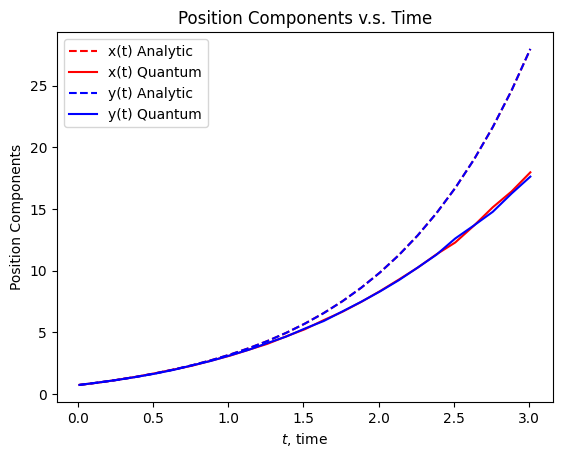

In [5]:
if __name__ == '__main__':

    # Define arrays to store information:
    x_C, y_C = [], []
    x_Q, y_Q = [], []
    
    for t in t_d:
        # Create circuit
        circuit = LDESolver(anc_reg1, anc_reg2, work_qubits, t)

        # Solve analytic expression
        x_analytic, y_analytic = solve_p(t, M, p0, b)

        # print(f"Analytic x({round(t, 3)}) = {round(x_analytic, 3)}")
        # print(f"Analytic y({round(t, 3)}) = {round(y_analytic, 3)}")
        #print(f"Quantum x({round(t, 3)}) = {round(circuit.x, 3)}")
        #print(f"Quantum y({round(t, 3)}) = {round(circuit.y, 3)}")

        # Store results
        x_C.append(x_analytic)
        y_C.append(y_analytic)
        x_Q.append(circuit.x) # They are not returned directly from the class, they are calculated and stored. 
        y_Q.append(circuit.y) # They are not returned directly from the class, they are calculated and stored. 

    # Plot results
    plt.plot(t_d, x_C, 'r--', label='x(t) Analytic')
    plt.plot(t_d, x_Q, 'r', label='x(t) Quantum')

    plt.plot(t_d, y_C, 'b--', label='y(t) Analytic')
    plt.plot(t_d, y_Q, 'b', label='y(t) Quantum')

    plt.xlabel(r"$t$, time")
    plt.ylabel(r"Position Components")

    plt.legend(loc='best')
    plt.title("Position Components v.s. Time")

    plt.show()

    #plt.plot(x_C, y_C, 'k--', label='Analytic')
    #plt.plot(x_Q, y_Q, 'r', label='Quantum')
    #plt.legend(loc='best')
    #plt.xlabel(r"$x(t)$")
    #plt.ylabel(r"$y(t)$")
    #plt.title("XY Phase Space")

    #plt.show()

The vector p typically represents a state in a multi-dimensional space, and "x" and "y" components represent two specific dimensions or components of the state. So, when we solve this matrix LDE, we are actually solving for the time evolution of both the "x" and "y" components of the state "p" over time "t."

## (2) Systems of (linear) coupled equations - HLL

- Reference: [hhl_experiment](https://github.com/quantastica/hhl_experiment/tree/master).
- Interesting lectures: [El algoritmo HHL](https://www.youtube.com/watch?v=vBHTKxahLhk&list=PLhYoqmIacCv8qQNpNMZBruq18ciFbBUEA), and [HHL Algorithm: Solving Systems of Linear Equations](https://medium.com/mit-6-s089-intro-to-quantum-computing/hhl-algorithm-solving-systems-of-linear-equations-e4d82d340951).

The **HHL (Harrow-Hassidim-Lloyd)** algorithm is primarily designed for solving systems of linear equations, particularly those that arise in scientific and engineering applications. It is a quantum algorithm for solving linear systems of equations of the form |A>x = |b>, where |A> is a Hermitian matrix (**VERY IMPORTANT**), |b> is a known vector, and x is the vector we want to know. We want to construct |x>.

The algorithm can be used to construct the vector |x>. This can be applied to many problems, including solving a system of coupled linear equations. In a system of coupled linear equations, we have multiple linear equations with multiple variables that are interconnected.

In [6]:
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import Statevector

def is_symetric(a, rtol=1e-05, atol=1e-08): # To check is a is symmetric. rtol and atol are tolerance parameters.
    return np.allclose(a, a.T, rtol=rtol, atol=atol) # Compare it to the transpose with np.allclose.


def linalg_qsolve(A, b, verbose=False, print_qasm=False): # Remember Ax=b.
    matrix = A.copy()
    vector = b.copy()
    
    # Rescale problem to log2.
    if(np.log2(len(matrix)) < np.ceil(np.log2(len(matrix)))):
        while np.log2(len(matrix)) < np.ceil(np.log2(len(matrix))):
            matrix = np.vstack([matrix, np.zeros(len(matrix))])
            matrix = np.c_[ matrix, np.append(np.zeros(len(matrix) - 1), -1) ]

        while np.log2(len(vector)) < np.ceil(np.log2(len(vector))):
            vector = np.append(vector, [0])

    # Check if input is hermitian. # VERY IMPORTANT FOR HHL.
    if(not is_symetric(matrix)):
        # Convert A to hermitian in worst case scenario.
        Z = np.zeros((len(matrix), len(matrix)))
        matrix = np.block([[Z, matrix], [matrix.T, Z]])

        # Rescale b:
        vector = np.append(np.zeros(len(vector)), vector)

    hhl_solution = HHL().solve(matrix, vector) # We have HHL in qiskit, yay!
    
    state_vector = Statevector(hhl_solution.state).data
    
    num_qubits = hhl_solution.state.num_qubits
    offset = 2**(num_qubits - 1)
    x = [] # The solution is converted into a real-valued vector x.
    for index in range(len(vector)):
        x.append(state_vector[offset + index])

    x = np.real(x)
    
    x = hhl_solution.euclidean_norm * (x / np.linalg.norm(x))

    if(verbose): # This is extra to compare with the classical solution.
        # Get classical solution (to compare with quantum solution)
        xc = np.linalg.solve(A, b)
        
        print("Classical solution:", xc)
        print("Quantum solution:  ", x)

        display(hhl_solution.state.draw(output="mpl"))
        transpiled = transpile(hhl_solution.state, basis_gates=['id', 'u3', 'cx'], optimization_level=3)
        print(transpiled.count_ops())
    
    if(print_qasm): # Human-readable.
        print(transpiled.qasm())
        
    return x


*** Problem 1 ***



C:\Users\dafda\AppData\Local\Temp\ipykernel_25352\3233648818.py:30: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  hhl_solution = HHL().solve(matrix, vector) # We have HHL in qiskit, yay!


Classical solution: [ 0.86023308 -1.48719142]
Quantum solution:   [ 0.87786206 -1.46956242]


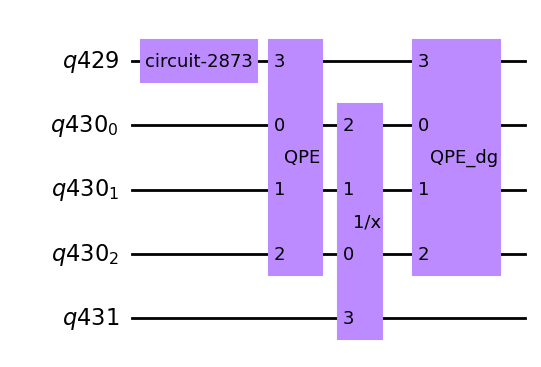

OrderedDict([('u3', 119), ('cx', 90)])



*** Problem 2 ***

Classical solution: [-0.00686554 -0.60915108]
Quantum solution:   [-0.01168517 -0.60433144]


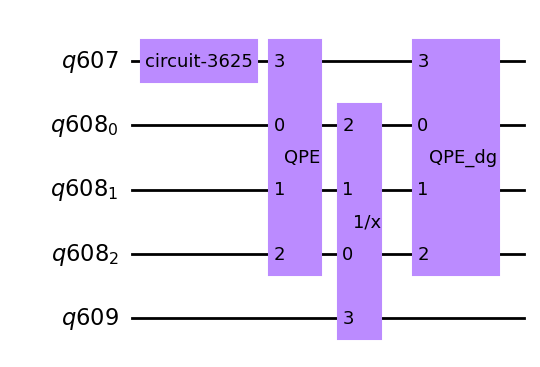

OrderedDict([('u3', 120), ('cx', 90)])




In [7]:
problems = [ 
    {
        "A": np.array([
            [0.86540304, 0.35951908],
            [0.35951908, 0.86540304]
        ]),

        "b": np.array([ 0.20977463, -0.97774977])
    },

    {
        "A": np.array([
            [ 1.64120030,  -0.08631518 ],
            [-0.08631518,   1.64120030 ]
        ]),

        "b": np.array([ 0.04131126, -0.99914633])
    }
]


for problem_index in range(len(problems)):
    print("\n*** Problem", str(problem_index + 1), "***\n")

    problem = problems[problem_index]

    x = linalg_qsolve(problem["A"], problem["b"], verbose=True, print_qasm=False)

    print("\n")

In [ ]:
# Just by fun, Qiskit example:
from qiskit.algorithms.linear_solvers.matrices import TridiagonalToeplitz
from qiskit.algorithms.linear_solvers.observables import MatrixFunctional

matrix = TridiagonalToeplitz(2, 1, 1 / 3, trotter_steps=2)
right_hand_side = [1.0, -2.1, 3.2, -4.3]
observable = MatrixFunctional(1, 1 / 2)
rhs = right_hand_side / np.linalg.norm(right_hand_side)

# Initial state circuit
num_qubits = matrix.num_state_qubits
qc = QuantumCircuit(num_qubits)
qc.isometry(rhs, list(range(num_qubits)), None)

hhl = HHL()
solution = hhl.solve(matrix, qc, observable)
approx_result = solution.observable

In [ ]:
print(approx_result)